In [1]:
%matplotlib inline

In [2]:
# !pip install torchmetrics

Translation with a Sequence to Sequence Network
*************************************************************

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.


**Requirements**



Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site http://tatoeba.org/ which has
downloads available at http://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



In [3]:
# !wget http://www.manythings.org/anki/fra-eng.zip
# !unzip -o fra-eng.zip
# !mkdir data
# !mv fra.txt data/eng-fra.txt

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "<PAD>"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [7]:
MAX_LENGTH = 15

eng_prefixes = (
    "i am", "i m",
    "he is", "he s",
    "she is", "she s",
    "you are", "you re",
    "we are", "we re",
    "they are", "they re"
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
# input_lang.addWord("<pad>")
# output_lang.addWord("<pad>")
#print(random.choice(pairs))

Reading lines...
Read 232736 sentence pairs
Trimmed to 22907 sentence pairs
Counting words...
Counted words:
fra 7019
eng 4638


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = [i[0] for i in pairs]
y = [i[1] for i in pairs]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
train_pairs = list(zip(X_train,y_train))
test_pairs = list(zip(X_test,y_test))

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.






In [13]:
ust_lstm = False
bidirectional = False
attention = False
useTransformer = False
case = 0

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=bidirectional)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        if self.bidirectional:
            return (torch.zeros(2, 1, self.hidden_size, device=device), torch.zeros(2, 1, self.hidden_size, device=device))
        else:
            return (torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device))

In [16]:

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 15):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class Transformer(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.1):
        super().__init__()
        self.hidden_size = d_model
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        # self.out = nn.Linear()
        self.linear = nn.Linear(d_model*MAX_LENGTH, d_model)
        self.flatten = nn.Flatten(start_dim=0)
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # self.linear.bias.data.zero_()
        # self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.embedding(src)
        src = self.pos_encoder(src)
        
        if False: #src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src, src_mask)
        output = torch.mean(output, dim=0, keepdim=True)
        # output = self.linear(self.flatten(output))
        return output



The Decoder (Your assignment)
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).


In [17]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Your code here #
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0])+1e-10)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, max_length, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.attn = nn.Linear(self.embedding_size + self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.embedding_size + self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # print(attn_weights.size(), encoder_outputs.size())
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
class AttDecoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(AttDecoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        # Your code here #
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # output = self.softmax(self.out(output[0]))
        return output, hidden
    def concat_forward(self, input):
        output = self.softmax(self.out(input))
        return output

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):

        # Your code here #
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device))

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [21]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [22]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    if not useTransformer:
        encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    if attention:
        encoder_hidden_states = torch.zeros(max_length, 1, 1, encoder.hidden_size, device=device)

    loss = 0

    if useTransformer:
        # temp_input_tensor = torch.ones(max_length, dtype=torch.long, device=device)*2
        # temp_output_tensor = torch.ones((max_length, 1), dtype=torch.long, device=device)*2
        # temp_input_tensor[:input_length] = input_tensor.squeeze(1)
        # temp_output_tensor[:target_length] = target_tensor
        # input_tensor = temp_input_tensor
        # target_tensor = temp_output_tensor
        # input_length = input_tensor.size(0)
        # target_length = target_tensor.size(0)
        encoder_hidden = encoder(input_tensor)
        # encoder_hidden = encoder_hidden.unsqueeze(0).unsqueeze(0)
        
        # encoder_hidden = torch.mean(encoder_hidden, dim=0).unsqueeze(0) # TODO
        
    else:
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            # print(encoder_output[0, 0].size(), encoder_hidden[0].size())
            encoder_outputs[ei] = encoder_output[0, 0] if not bidirectional else (encoder_output[0, 0][:hidden_size] + encoder_output[0, 0][hidden_size:])/2
            if attention:
                encoder_hidden_states[ei] = encoder_hidden

    decoder_input = torch.tensor([[SOS_token]], device=device)

    if not bidirectional:
        decoder_hidden = encoder_hidden
    else:
        decoder_hidden = []
        decoder_hidden.append(torch.mean(encoder_hidden[0], dim=0).unsqueeze(0))
        decoder_hidden.append(torch.mean(encoder_hidden[1], dim=0).unsqueeze(0))
        decoder_hidden = tuple(decoder_hidden)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    softmax = nn.Softmax(0)
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # decoder_output, decoder_hidden = decoder(
            #     decoder_input, decoder_hidden)
            if attention:
                # cal attention score
                attn_scr = torch.sum(encoder_hidden_states * torch.squeeze(decoder_hidden), dim=-1).squeeze()
                attn_scr = softmax(attn_scr)
                # print(attn_scr.size())
                # attn_scr = torch.matmul(encoder_hidden_states, decoder_hidden)
                attn_ws = torch.sum(encoder_hidden_states * attn_scr.view(-1, 1, 1, 1), dim=0)
                decoder_hidden = (decoder_hidden + attn_ws)/2
                # decoder_output = decoder.concat_forward(decoder_output).squeeze(0)
            if case == 3:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            # print(decoder_output, target_tensor)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if attention:
                # cal attention score
                attn_scr = torch.sum(encoder_hidden_states * torch.squeeze(decoder_hidden), dim=-1).squeeze()
                attn_scr = softmax(attn_scr)
                # print(attn_scr.size())
                attn_ws = torch.sum(encoder_hidden_states * attn_scr.view(-1, 1, 1, 1), dim=0)   
                decoder_hidden = (decoder_hidden + attn_ws)/2
                # decoder_output = decoder.concat_forward(decoder_output).squeeze(0)
            if case == 3:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            
            loss += criterion(decoder_output, target_tensor[di])
            # if loss == torch.nan:
            #     print(decoder_output, target_tensor)
                
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    # if not (loss / target_length) > 0:
    #     print(loss, target_length)
    
    return loss / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [23]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [24]:
from torchmetrics.text.rouge import ROUGEScore
# from tqdm import tqdm
import numpy as np

rouge = ROUGEScore()

def test(encoder, decoder, testing_pairs):
    input = []
    gt = []
    predict = []
    metric_score = {
        "rouge1_fmeasure":[],
        "rouge1_precision":[],
        "rouge1_recall":[],
        "rouge2_fmeasure":[],
        "rouge2_precision":[],
        "rouge2_recall":[]
    }

    for i in range(len(testing_pairs)):
        pair = testing_pairs[i]
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)

        input.append(pair[0])
        gt.append(pair[1])
        predict.append(output_sentence)

        try:
            rs = rouge(output_sentence, pair[1])
        except:
            continue
        metric_score["rouge1_fmeasure"].append(rs['rouge1_fmeasure'])
        metric_score["rouge1_precision"].append(rs['rouge1_precision'])
        metric_score["rouge1_recall"].append(rs['rouge1_recall'])
        metric_score["rouge2_fmeasure"].append(rs['rouge2_fmeasure'])
        metric_score["rouge2_precision"].append(rs['rouge2_precision'])
        metric_score["rouge2_recall"].append(rs['rouge2_recall'])

    metric_score["rouge1_fmeasure"] = np.array(metric_score["rouge1_fmeasure"]).mean()
    metric_score["rouge1_precision"] = np.array(metric_score["rouge1_precision"]).mean()
    metric_score["rouge1_recall"] = np.array(metric_score["rouge1_recall"]).mean()
    metric_score["rouge2_fmeasure"] = np.array(metric_score["rouge2_fmeasure"]).mean()
    metric_score["rouge2_precision"] = np.array(metric_score["rouge2_precision"]).mean()
    metric_score["rouge2_recall"] = np.array(metric_score["rouge2_recall"]).mean()

    print("=== Evaluation score - Rouge score ===")
    print("Rouge1 fmeasure:\t",metric_score["rouge1_fmeasure"])
    print("Rouge1 precision:\t",metric_score["rouge1_precision"])
    print("Rouge1 recall:  \t",metric_score["rouge1_recall"])
    print("Rouge2 fmeasure:\t",metric_score["rouge2_fmeasure"])
    print("Rouge2 precision:\t",metric_score["rouge2_precision"])
    print("Rouge2 recall:  \t",metric_score["rouge2_recall"])
    print("=====================================")
    return input,gt,predict,metric_score

# def deep_copy_model(model):
#     # Create a new instance of the model
#     # new_model = copy.deepcopy(model)
    
#     # Load the state_dict of the original model into the new model
#     # new_model.load_state_dict(model.state_dict())
    
#     return new_model

In [25]:
import pytorch_warmup as warmup

def trainIters(encoder, decoder, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    best_score = 0
    best_epoch = 0

    steps_per_epoch = len(train_pairs)
    warmup_period = len(train_pairs)
    num_steps = steps_per_epoch * epochs - warmup_period
    t0 = num_steps // 3
    lr_min = 1e-6
    max_step = t0 * 3 + warmup_period

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    e_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            encoder_optimizer, T_0=t0, T_mult=1, eta_min=lr_min)

    e_warmup_scheduler = warmup.LinearWarmup(encoder_optimizer, warmup_period)
    
    d_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            decoder_optimizer, T_0=t0, T_mult=1, eta_min=lr_min)

    d_warmup_scheduler = warmup.LinearWarmup(decoder_optimizer, warmup_period)

    criterion = nn.NLLLoss()

    iter = 1
    n_iters = len(train_pairs) * epochs
    
    best_encoder_state = None
    best_decoder_state = None

    for epoch in range(1, epochs+1):
        print("Epoch: %d/%d" % (epoch, epochs))
        # old_encoder = deep_copy_model(encoder)
        # old_decoder = deep_copy_model(decoder)
        for training_pair in train_pairs:
            training_pair = tensorsFromPair(training_pair)

            input_tensor = training_pair[0]
            target_tensor = training_pair[1]

            loss = train(input_tensor, target_tensor, encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss
            
            with e_warmup_scheduler.dampening():
                if e_warmup_scheduler.last_step + 1 >= warmup_period:
                    e_lr_scheduler.step()
            # if e_warmup_scheduler.last_step + 1 >= max_step:
            #     break
            
            with d_warmup_scheduler.dampening():
                if d_warmup_scheduler.last_step + 1 >= warmup_period:
                    d_lr_scheduler.step()
            # if d_warmup_scheduler.last_step + 1 >= max_step:
            #     break

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                            iter, iter / n_iters * 100, print_loss_avg))
                plot_losses.append(print_loss_avg)

            iter +=1
        input,gt,predict,score = test(encoder, decoder, test_pairs)
        if np.mean(np.array([score['rouge1_fmeasure'], score['rouge2_fmeasure']])) <= best_score: #and (epoch - best_epoch) > 10:
            # break
            pass
        else:
            # best_encoder_state = encoder.state_dict()
            # best_decoder_state = decoder.state_dict()
            torch.save(encoder.state_dict(), 'encoder_weights.pth')
            torch.save(decoder.state_dict(), 'decoder_weights.pth')
            best_score = np.mean(np.array([score['rouge1_fmeasure'], score['rouge2_fmeasure']]))
    encoder.load_state_dict(torch.load('encoder_weights.pth'))
    decoder.load_state_dict(torch.load('decoder_weights.pth'))
    return plot_losses

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [26]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        if not useTransformer:
            encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        if attention:
            encoder_hidden_states = torch.zeros(max_length, 1, 1, encoder.hidden_size, device=device)

        if useTransformer:
            encoder_hidden = encoder(input_tensor)
            encoder_hidden = torch.mean(encoder_hidden, dim=0).unsqueeze(0)
        else:
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                        encoder_hidden)
                if attention:
                    encoder_hidden_states[ei] = encoder_hidden
                encoder_outputs[ei] += encoder_output[0, 0] if not bidirectional else (encoder_output[0, 0][:hidden_size] + encoder_output[0, 0][hidden_size:])/2

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        if not bidirectional:
            decoder_hidden = encoder_hidden
        else:
            decoder_hidden = []
            decoder_hidden.append(torch.mean(encoder_hidden[0], dim=0).unsqueeze(0))
            decoder_hidden.append(torch.mean(encoder_hidden[1], dim=0).unsqueeze(0))
            decoder_hidden = tuple(decoder_hidden)

        decoded_words = []
        softmax = nn.Softmax(0)
        for di in range(max_length):
            if attention:
                # cal attention score
                attn_scr = torch.sum(encoder_hidden_states * torch.squeeze(decoder_hidden), dim=-1).squeeze()
                # attn_scr = torch.matmul(encoder_hidden_states, decoder_hidden)
                attn_scr = softmax(attn_scr)
                attn_ws = torch.mean(encoder_hidden_states * attn_scr.view(-1, 1, 1, 1), dim=0)   
                decoder_hidden = (decoder_hidden + attn_ws)/2
                # decoder_output = decoder.concat_forward(decoder_output)
            if case == 3:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [27]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [28]:
# from torchmetrics.text.rouge import ROUGEScore
# # from tqdm import tqdm
# import numpy as np

# rouge = ROUGEScore()

# def test(encoder, decoder, testing_pairs):
#     input = []
#     gt = []
#     predict = []
#     metric_score = {
#         "rouge1_fmeasure":[],
#         "rouge1_precision":[],
#         "rouge1_recall":[],
#         "rouge2_fmeasure":[],
#         "rouge2_precision":[],
#         "rouge2_recall":[]
#     }

#     for i in range(len(testing_pairs)):
#         pair = testing_pairs[i]
#         output_words = evaluate(encoder, decoder, pair[0])
#         output_sentence = ' '.join(output_words)

#         input.append(pair[0])
#         gt.append(pair[1])
#         predict.append(output_sentence)

#         try:
#             rs = rouge(output_sentence, pair[1])
#         except:
#             continue
#         metric_score["rouge1_fmeasure"].append(rs['rouge1_fmeasure'])
#         metric_score["rouge1_precision"].append(rs['rouge1_precision'])
#         metric_score["rouge1_recall"].append(rs['rouge1_recall'])
#         metric_score["rouge2_fmeasure"].append(rs['rouge2_fmeasure'])
#         metric_score["rouge2_precision"].append(rs['rouge2_precision'])
#         metric_score["rouge2_recall"].append(rs['rouge2_recall'])

#     metric_score["rouge1_fmeasure"] = np.array(metric_score["rouge1_fmeasure"]).mean()
#     metric_score["rouge1_precision"] = np.array(metric_score["rouge1_precision"]).mean()
#     metric_score["rouge1_recall"] = np.array(metric_score["rouge1_recall"]).mean()
#     metric_score["rouge2_fmeasure"] = np.array(metric_score["rouge2_fmeasure"]).mean()
#     metric_score["rouge2_precision"] = np.array(metric_score["rouge2_precision"]).mean()
#     metric_score["rouge2_recall"] = np.array(metric_score["rouge2_recall"]).mean()

#     print("=== Evaluation score - Rouge score ===")
#     print("Rouge1 fmeasure:\t",metric_score["rouge1_fmeasure"])
#     print("Rouge1 precision:\t",metric_score["rouge1_precision"])
#     print("Rouge1 recall:  \t",metric_score["rouge1_recall"])
#     print("Rouge2 fmeasure:\t",metric_score["rouge2_fmeasure"])
#     print("Rouge2 precision:\t",metric_score["rouge2_precision"])
#     print("Rouge2 recall:  \t",metric_score["rouge2_recall"])
#     print("=====================================")
#     return input,gt,predict,metric_score

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [29]:
import matplotlib.pyplot as plt
def plot(x):
    plt.plot(x)

In [30]:
hidden_size = 512

bidirectional = False
case = -1

if case == 0: # LSTM & bi-LSTM
    ust_lstm = True
    encoder1 = EncoderLSTM(input_lang.n_words, hidden_size, bidirectional=bidirectional).to(device)
    decoder1 = DecoderLSTM(hidden_size, output_lang.n_words).to(device)
elif case == 1: # wrong
    attention = True
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)
elif case == 2: # transformer
    useTransformer = True
    
    ntokens = input_lang.n_words # size of vocabulary
    emsize = hidden_size  # embedding dimension
    d_hid = 2048  # dimension of the feedforward network model in ``nn.TransformerEncoder``
    nlayers = 4  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
    nhead = 4  # number of heads in ``nn.MultiheadAttention``
    dropout = 0.1  # dropout probability
    encoder1 = Transformer(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
    decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)
elif case == 3: # improved attention
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    decoder1 = AttnDecoderRNN(hidden_size,
                                  hidden_size,
                                  output_lang.n_words,
                                  15,
                                  dropout_p=0.1).to(device)
elif case == 4: # improvement
    bidirectional = True
    encoder1 = EncoderLSTM(input_lang.n_words, hidden_size, bidirectional=bidirectional).to(device)
    decoder1 = AttnDecoderRNN(hidden_size,
                                  hidden_size,
                                  output_lang.n_words,
                                  15,
                                  dropout_p=0.1).to(device)
else:
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)
l = trainIters(encoder1, decoder1, 50, print_every=1000, learning_rate=6e-3)

Epoch: 1/50
0m 13s (- 223m 14s) (1000 0%) 6.2979
0m 25s (- 218m 29s) (2000 0%) 3.8931
0m 39s (- 223m 22s) (3000 0%) 3.6254
0m 51s (- 222m 6s) (4000 0%) 3.6650
1m 5s (- 224m 9s) (5000 0%) 3.6398
1m 18s (- 224m 0s) (6000 0%) 3.5854
1m 31s (- 223m 38s) (7000 0%) 3.5185
1m 44s (- 223m 39s) (8000 0%) 3.5175
1m 58s (- 224m 4s) (9000 0%) 3.5059
2m 11s (- 224m 7s) (10000 0%) 3.4548
2m 25s (- 224m 50s) (11000 1%) 3.3743
2m 39s (- 226m 4s) (12000 1%) 3.3585
2m 54s (- 227m 26s) (13000 1%) 3.2413
3m 8s (- 227m 37s) (14000 1%) 3.1713
3m 22s (- 228m 7s) (15000 1%) 3.1321
3m 35s (- 227m 43s) (16000 1%) 3.1184
3m 49s (- 227m 42s) (17000 1%) 3.1027
4m 3s (- 228m 24s) (18000 1%) 3.0910
4m 18s (- 229m 30s) (19000 1%) 3.1036
4m 32s (- 229m 55s) (20000 1%) 3.0247
=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.37897098
Rouge1 precision:	 0.39310345
Rouge1 recall:  	 0.37705496
Rouge2 fmeasure:	 0.19791102
Rouge2 precision:	 0.20158488
Rouge2 recall:  	 0.20355804
Epoch: 2/50
6m 9s (- 295m 55s) (

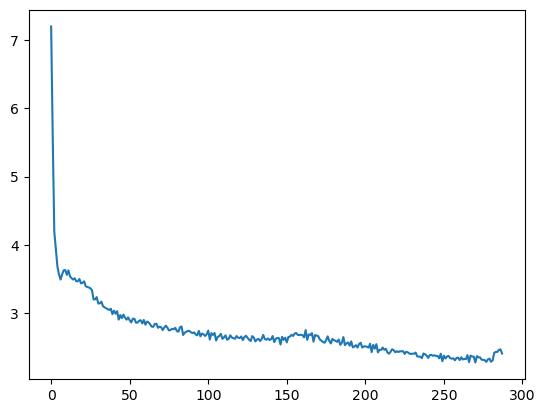

In [ ]:
if isinstance(l[0], torch.Tensor): l = [i.cpu().detach().numpy() for i in l]
plot(l)

In [ ]:
evaluateRandomly(encoder1, decoder1)

> il dit qu il doit se rendre a vienne apres demain .
= he says that he has to go to vienna the day after tomorrow .
< he said that he would be a . . . <EOS>

> j ai peur de ne pas etre d accord avec toi .
= i m afraid i don t agree with you .
< i m afraid i i t . . . . . <EOS>

> il est taciturne .
= he is a man of few words .
< he is a . <EOS>

> elle est photographe professionnelle .
= she s a professional photographer .
< she is a . . . <EOS>

> il est deja la .
= he is already here .
< he is very . . <EOS>

> ils sont frere et s ur .
= they re brother and sister .
< they re both in the . . <EOS>

> il est probable qu il gagne la partie .
= he is likely to win the game .
< he is always to to . . . <EOS>

> tu es adorable .
= you re adorable .
< you re nuts . <EOS>

> il se planque .
= he s gone into hiding .
< he is a . <EOS>

> je suis fatigue de tous ses mensonges .
= i m fed up with all their lies .
< i m sure of the . . . <EOS>



In [ ]:
input,gt,predict,score = test(encoder1, decoder1, train_pairs)

=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.4360251
Rouge1 precision:	 0.43233687
Rouge1 recall:  	 0.4500943
Rouge2 fmeasure:	 0.25591362
Rouge2 precision:	 0.25067902
Rouge2 recall:  	 0.27076897


In [ ]:
input,gt,predict,score = test(encoder1, decoder1, test_pairs)

=== Evaluation score - Rouge score ===
Rouge1 fmeasure:	 0.43335107
Rouge1 precision:	 0.4290823
Rouge1 recall:  	 0.4479097
Rouge2 fmeasure:	 0.25470656
Rouge2 precision:	 0.24900529
Rouge2 recall:  	 0.26992095


In [10]:
import re

with open("train_log.txt", "r") as txt:
    lines = txt.readlines()
    buffer = []
    cat = ""
    for line in lines:
        if line.startswith("seq2seq"):
            cat += " \\\\"
            buffer.append(cat)
            cat = line.split("\n")[0]
        else:
            if len(re.split(r':\s*', line.strip())) > 1:
                cat += " & " + str(round(float(re.split(r':\s*', line.strip())[1])*100, 2))
    buffer.append(cat+" \\\\")
    for i in buffer: print(i)
        

 \\
seq2seq (original) & 84.83 & 78.36 & 92.87 & 76.72 & 69.62 & 86.07 \\
seq2seq (LSTM) & 84.18 & 78.21 & 91.57 & 76.09 & 69.49 & 84.75 \\
seq2seq (bi-LSTM) & 85.58 & 79.35 & 93.29 & 78.13 & 71.2 & 87.2 \\
seq2seq (Attention) & 88.18 & 81.48 & 96.35 & 83.14 & 75.54 & 92.92 \\
seq2seq (Transformer Encoder) & 52.69 & 51.4 & 56.19 & 34.85 & 33.38 & 38.39 \\
seq2seq (BI-LSTM + Attention) & 84.77 & 78.55 & 92.38 & 77.18 & 70.34 & 85.99 \\


seq2seq (bi-LSTM) & 0.591 & 69.42\% \\
